In [1]:
import torch
import torch.nn as nn
from torchdiffeq import odeint_adjoint as odeint
import torch.nn.functional as F
import pdb

~~~
Input: 3 x 224 x 224

1. Conv1: 7x7, 64, stride=2 → 64 x 112 x 112
2. MaxPool: 3x3, stride=2   → 64 x 56 x 56

3. Conv2_x:
   [1x1, 64] → [3x3, 64] → [1x1, 256] × 3 次（包含残差连接）

4. Conv3_x:
   [1x1, 128] → [3x3, 128] → [1x1, 512] × 4 次（包含残差连接）

5. Conv4_x:
   [1x1, 256] → [3x3, 256] → [1x1, 1024] × 6 次（包含残差连接）

6. Conv5_x:
   [1x1, 512] → [3x3, 512] → [1x1, 2048] × 3 次（包含残差连接）

7. Average Pooling → 2048 x 1 x 1

8. Fully Connected (fc): 2048 → num_classes

Output: num_classes (通常为 1000 用于 ImageNet)
~~~

In [2]:
# --------------------------- ODE-utils ---------------------------
class ODEFunc(nn.Module):
    def __init__(self, channels):
        super(ODEFunc, self).__init__()
        self.norm = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, t, x):
        return self.conv(self.relu(self.norm(x)))

class ODEBlock(nn.Module):
    def __init__(self, odefunc, tol=1e-3):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()
        self.tol = tol

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, rtol=self.tol, atol=self.tol)
        return out[1]

In [3]:
# --------------------------- ODE-Bottleneck ---------------------------
class BottleneckODE(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None, tol=1e-3):
        super(BottleneckODE, self).__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        width = int(planes * (base_width / 64.)) * groups

        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False)
        self.bn1 = norm_layer(width)

        if stride != 1:
            self.downsample_input = nn.AvgPool2d(kernel_size=2, stride=2)
        else:
            self.downsample_input = None

        self.odeblock = ODEBlock(ODEFunc(width), tol=tol)

        self.conv3 = nn.Conv2d(width, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = norm_layer(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        if self.downsample_input:
            out = self.downsample_input(out)

        out = self.odeblock(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


In [4]:
# --------------------------- ODE-ResNet50 ---------------------------
from torchvision.models.resnet import ResNet

class ODEResNet50(nn.Module):
    def __init__(self):
        super(ODEResNet50, self).__init__()
        self.base = ResNet(block=BottleneckODE, layers=[3, 4, 6, 3])
        self.base.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 1通道适配 #RGBA图像读取转化成RGB图像

    def forward(self, x):
        layers = []
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)
        layers.append(x)  # 0

        x = self.base.maxpool(x)
        x = self.base.layer1(x)
        layers.append(x)  # 1: shallow layer

        x = self.base.layer2(x)
        x = self.base.layer3(x)
        x = self.base.layer4(x)
        layers.append(x)  # 2: deep layer

        return layers[1], layers[2]  # shallow, deep

In [5]:
# --------------------------- ASPP Module ---------------------------
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous_block1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.atrous_block6 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=6, dilation=6)
        self.atrous_block12 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=12, dilation=12)
        self.atrous_block18 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=18, dilation=18)
        self.global_avg_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
        )
        self.conv1x1 = nn.Conv2d(out_channels * 5, out_channels, kernel_size=1)

    def forward(self, x):
        size = x.shape[2:]
        out1 = self.atrous_block1(x) ## 1x1 Conv
        out2 = self.atrous_block6(x) ## 3x3 Conv Padding = 6
        out3 = self.atrous_block12(x) ## 3x3 Conv Padding = 12
        out4 = self.atrous_block18(x) ## 3x3 Conv Padding = 18
        out5 = self.global_avg_pool(x) ## 3x3 Conv Padding = 18
        out5 = F.interpolate(out5, size=size, mode='bilinear', align_corners=True)
        out = torch.cat([out1, out2, out3, out4, out5], dim=1)
        return self.conv1x1(out)

In [6]:
# --------------------------- Segmentation Model ---------------------------
class SegNetODE(nn.Module):
    def __init__(self, num_classes):
        super(SegNetODE, self).__init__()
        self.encoder = ODEResNet50()
        self.aspp = ASPP(in_channels=2048, out_channels=256)
        self.low_level_conv = nn.Conv2d(256, 48, kernel_size=1)

        self.decoder = nn.Sequential(
            nn.Conv2d(256 + 48, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True),
            nn.Conv2d(256, num_classes, kernel_size=1)
        )

    def forward(self, x): ##x.shape = torch.Size([4, 3, 256, 256])[batch_size = 4,RGBA = 4,(x,y) = (256,256)]
        # pdb.set_trace()
        shallow, x = self.encoder(x)  # 返回两个分辨率的特征
        x = self.aspp(x)
        x = F.interpolate(x, scale_factor=4, mode='bilinear', align_corners=True)
        shallow = self.low_level_conv(shallow)
        shallow = F.interpolate(shallow, size=x.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, shallow], dim=1)
        return self.decoder(x)
    

# Train

In [7]:
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np
import os

In [8]:
data_path = "/root/workspace/ssd/txj_workspace/hawkyu/hawkyu/remote_sence/dataset/data"
img_path = data_path + '/JPEGImages'
mask_path = data_path + '/Annotations'
models_path = data_path + '/Models'

In [9]:
# --------------------------- Dataset ---------------------------
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = transforms.Compose([
              transforms.Resize((256, 256), interpolation=Image.NEAREST),
              transforms.Lambda(lambda x: torch.from_numpy(np.array(x)).long())
            ])(mask)
        
        return image, mask
    

In [10]:
# --------------------------- Dice + CE Loss ---------------------------
class DiceCELoss(nn.Module):
    def __init__(self, weight_dice=1.0, weight_ce=1.0, smooth=1.0):
        super(DiceCELoss, self).__init__()
        self.weight_dice = weight_dice
        self.weight_ce = weight_ce
        self.smooth = smooth
        self.ce = nn.CrossEntropyLoss()

    def forward(self, preds, targets):
        ce_loss = self.ce(preds, targets)
        dice_loss = self._dice_loss(preds, targets)
        return self.weight_ce * ce_loss + self.weight_dice * dice_loss

    def _dice_loss(self, preds, targets):
        probs = torch.softmax(preds, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=preds.shape[1]).permute(0, 3, 1, 2).float()
        dims = (0, 2, 3)
        intersection = torch.sum(probs * targets_one_hot, dims)
        cardinality = torch.sum(probs + targets_one_hot, dims)
        dice_score = (2. * intersection + self.smooth) / (cardinality + self.smooth)
        return 1 - dice_score.mean()

In [11]:
# --------------------------- Training and Validation ---------------------------
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for imgs, masks in loader:
        imgs, masks = imgs.cuda(), masks.cuda()
        preds = model(imgs) 
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader) # average_loss

def validate_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.cuda(), masks.cuda()
            preds = model(imgs)
            loss = criterion(preds, masks)
            total_loss += loss.item()
    return total_loss / len(loader)


In [12]:

# --------------------------- Train Script ---------------------------
def train():
    image_dir = img_path
    mask_dir = mask_path
    epoch_num = 9

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])


    dataset = SegmentationDataset(image_dir, mask_dir, transform = transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)


    ## 掩码背景全为零

    model = SegNetODE(num_classes=5).cuda()
    criterion = DiceCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(1, epoch_num):
        train_loss = train_epoch(model, train_loader, optimizer, criterion)
        val_loss = validate_epoch(model, val_loader, criterion)

        print(f"Epoch {epoch}: Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f}")

        torch.save(model.state_dict(), f"model_epoch{epoch}.pth")
    

    save_path = os.path.join(models_path, "Train_03.pth")
    torch.save(model.state_dict(), save_path)
    print("Model saved successfully!")


In [ ]:
train()

Epoch 1: Train Loss=0.5004 | Val Loss=0.3298
Epoch 2: Train Loss=0.2997 | Val Loss=0.3225
Epoch 3: Train Loss=0.2205 | Val Loss=0.2040
Epoch 4: Train Loss=0.1825 | Val Loss=0.2487
Epoch 5: Train Loss=0.1537 | Val Loss=0.3049


# Evaluation

In [ ]:
models_path = data_path + '/Models'

In [ ]:
def calculate_mIoU(preds, labels, num_classes):
    """
    计算 mean IoU
    preds: 预测结果，Tensor，形状为 [B, H, W]，取值为类别索引
    labels: 真实标签，Tensor，形状为 [B, H, W]，取值为类别索引
    num_classes: 类别数
    """
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (labels == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()

        if union == 0:
            ious.append(float('nan'))  # 当前类别在这张图中没有出现
        else:
            ious.append(intersection / union)
    # 返回所有类别的 mIoU（排除 nan）
    return np.nanmean(ious)

In [ ]:
@torch.no_grad()
def evaluate_model(model, dataloader, num_classes=5, max_samples=10):
    model.eval()
    total_miou = 0
    count = 0

    for i, (images, masks) in enumerate(dataloader):
        if i >= max_samples:  # 只验证前 max_samples 个样本
            break

        images = images.cuda()
        masks = masks.cuda()

        outputs = model(images)  # [B, C, H, W]
        preds = torch.argmax(outputs, dim=1)  # [B, H, W]

        for b in range(images.size(0)):
            miou = calculate_mIoU(preds[b], masks[b], num_classes)
            print(f"Image {count + 1} mIoU: {miou:.4f}")
            total_miou += miou
            count += 1

    avg_miou = total_miou / count
    print(f"\n✅ Average mIoU over {count} samples: {avg_miou:.4f}")

In [ ]:
## miou作为验证指标
def eval_miou():
    # 修改为你的路径
    model_path = models_path + "/Train_02.pth"
    image_dir = img_path
    mask_dir = mask_path
    num_classes = 5

    # 加载模型
    model = SegNetODE(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path))
    model = model.cuda()

    # 数据变换
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    # 数据加载
    dataset = SegmentationDataset(image_dir, mask_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    # 验证模型
    evaluate_model(model, dataloader, num_classes=num_classes, max_samples=1000)
    

In [ ]:
eval_miou()

## calcuate confusion martix

In [ ]:
import numpy as np
import torch

def compute_confusion_matrix(preds, labels, num_classes):
    """
    preds: Tensor[B, H, W] - 预测标签
    labels: Tensor[B, H, W] - 真实标签
    return: (num_classes, num_classes) 混淆矩阵
    """
    preds = preds.view(-1).cpu().numpy()
    labels = labels.view(-1).cpu().numpy()
    mask = (labels >= 0) & (labels < num_classes)
    conf_matrix = np.bincount(
        num_classes * labels[mask] + preds[mask],
        minlength=num_classes**2
    ).reshape(num_classes, num_classes)
    return conf_matrix


In [ ]:
@torch.no_grad()
def evaluate_model_confusion(model, dataloader, num_classes=5, max_samples=None):
    model.eval()
    total_conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)
    count = 0

    for i, (images, masks) in enumerate(dataloader):
        if max_samples is not None and count >= max_samples:
            break

        images = images.cuda()
        masks = masks.cuda()

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        conf = compute_confusion_matrix(preds, masks, num_classes)
        total_conf_matrix += conf
        count += images.size(0)

    print("✅ 混淆矩阵（行=真实，列=预测）:")
    print(total_conf_matrix)

    # 可选：计算mIoU
    ious = []
    for i in range(num_classes):
        tp = total_conf_matrix[i, i]
        fn = total_conf_matrix[i, :].sum() - tp
        fp = total_conf_matrix[:, i].sum() - tp
        denom = tp + fp + fn
        if denom == 0:
            iou = np.nan
        else:
            iou = tp / denom
        ious.append(iou)
        print(f"Class {i}: IoU = {iou:.4f}")

    mean_iou = np.nanmean(ious)
    print(f"✅ Evaluated {count} image(s) for confusion matrix and mIoU.")
    print(f"\n✅ Mean IoU: {mean_iou:.4f}")

In [ ]:
def eval_confusion_martix():
    # 修改为你的路径
    model_path = models_path + "/Train_02.pth"
    image_dir = img_path
    mask_dir = mask_path
    num_classes = 5

    # 加载模型
    model = SegNetODE(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path))
    model = model.cuda()

    # 数据变换
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    # 数据加载
    dataset = SegmentationDataset(image_dir, mask_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    # 验证模型
    evaluate_model_confusion(model, dataloader, num_classes=num_classes, max_samples=1000)

In [ ]:
eval_confusion_martix()

# 可视化图

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image

In [12]:
data_path = "/root/workspace/ssd/txj_workspace/hawkyu/hawkyu/remote_sence/dataset/data"
img_path = data_path + '/JPEGImages'
mask_path = data_path + '/Annotations'
models_path = data_path + '/Models'

In [13]:
def visual():
    # 设置路径
    model_path = models_path + "/Train_02.pth"
    image_dir = img_path
    mask_dir = mask_path
    num_classes = 5

    # 加载模型
    model = SegNetODE(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path))
    model = model.cuda()
    model.eval()

    # 图像预处理
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    # 加载数据集
    dataset = SegmentationDataset(image_dir, mask_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    # 展示前5张图像的预测掩码
    for idx, (images, masks) in enumerate(dataloader):
        if idx >= 20:
            break

        images = images.cuda()
        with torch.no_grad():
            outputs = model(images)  # shape: (1, num_classes, H, W)
            preds = torch.argmax(outputs.squeeze(0), dim=0).cpu().numpy()  # shape: (H, W)

        # 可视化
        plt.figure(figsize=(12, 4))

        # 原图
        plt.subplot(1, 3, 1)
        img_np = images.squeeze().cpu().numpy()
        if img_np.shape[0] == 3:
            plt.imshow(np.transpose(img_np, (1, 2, 0)))
        else:
            plt.imshow(img_np[0], cmap='gray')
        plt.title(f"Image {idx+1}")
        plt.axis('off')

        # 真实掩码
        plt.subplot(1, 3, 2)
        plt.imshow(masks.squeeze().cpu(), cmap='tab20')
        plt.title("Ground Truth")
        plt.axis('off')

        # 预测掩码
        plt.subplot(1, 3, 3)
        plt.imshow(preds, cmap='tab20')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

/tmp/ipykernel_9796/2614871510.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


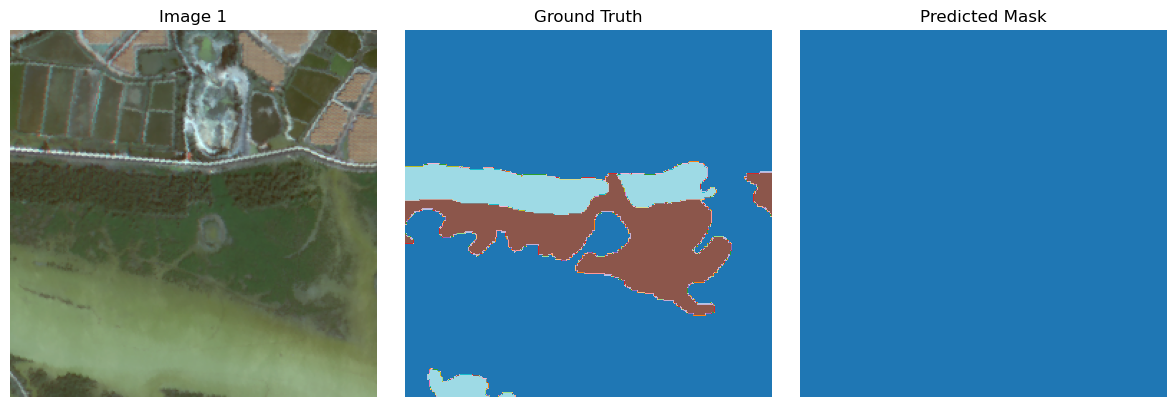

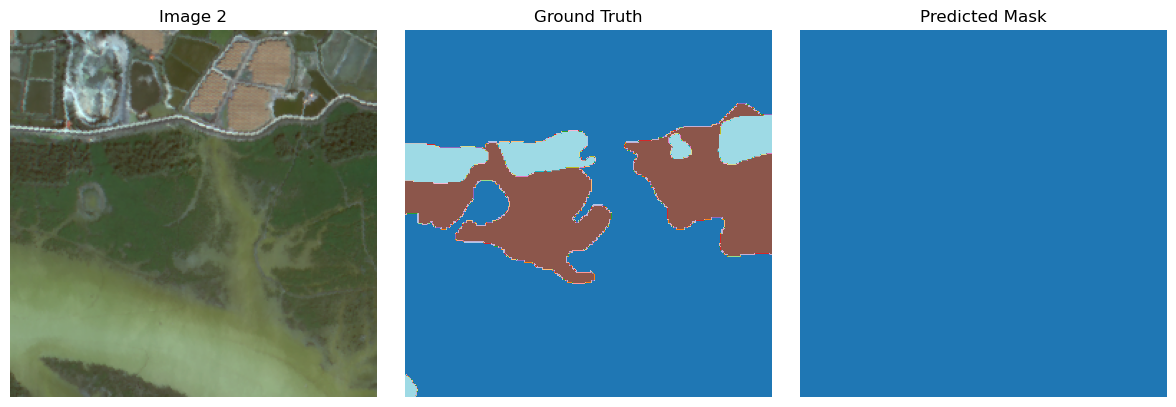

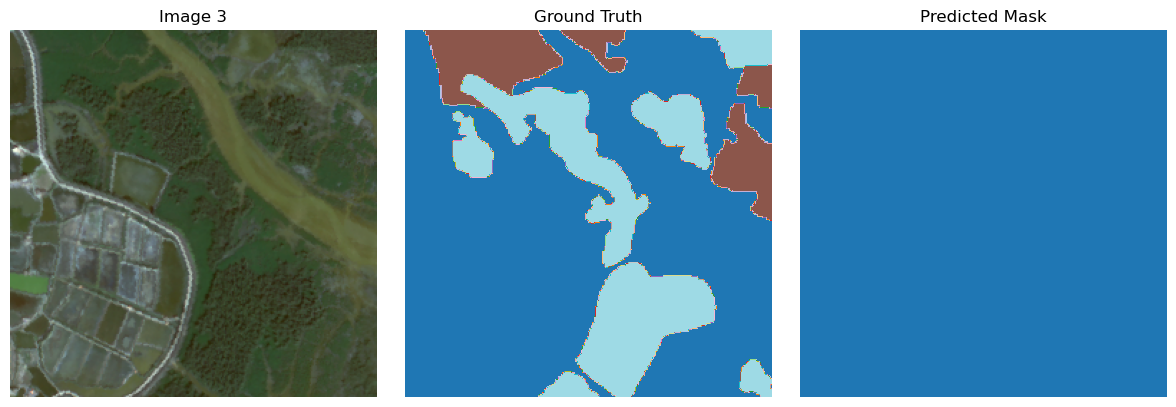

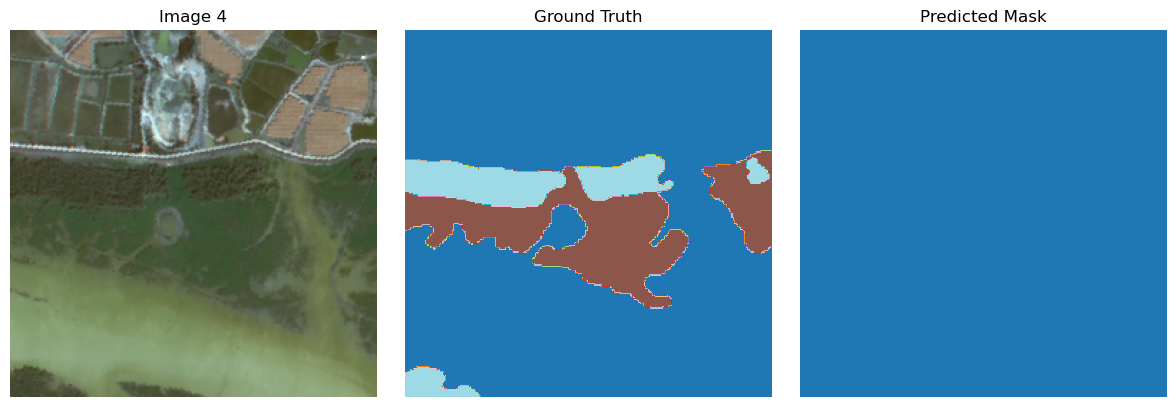

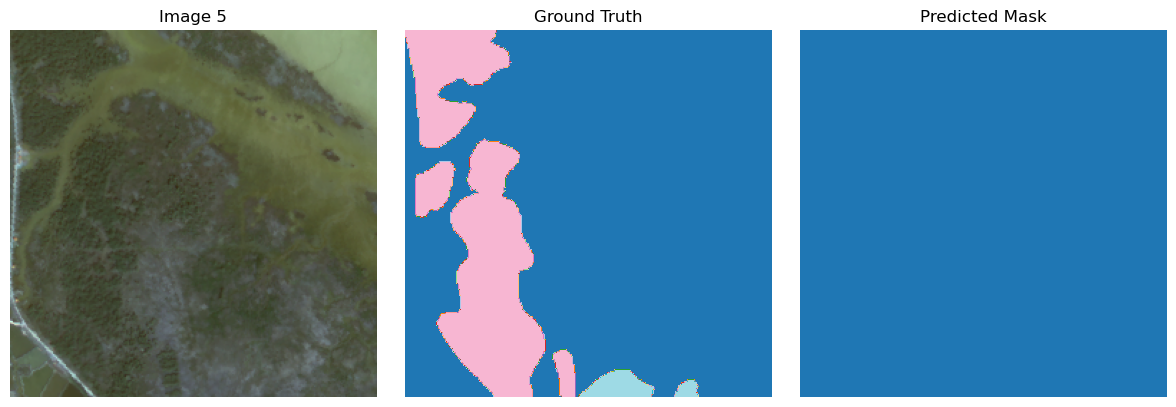

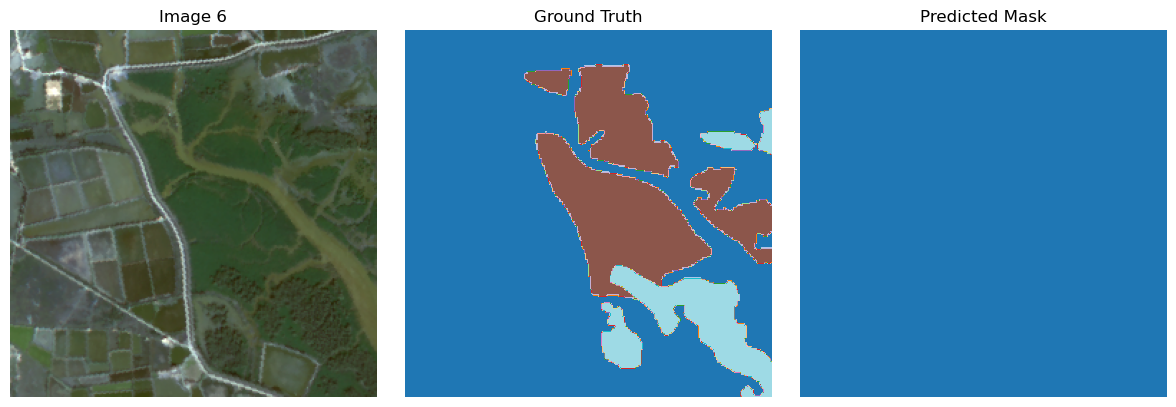

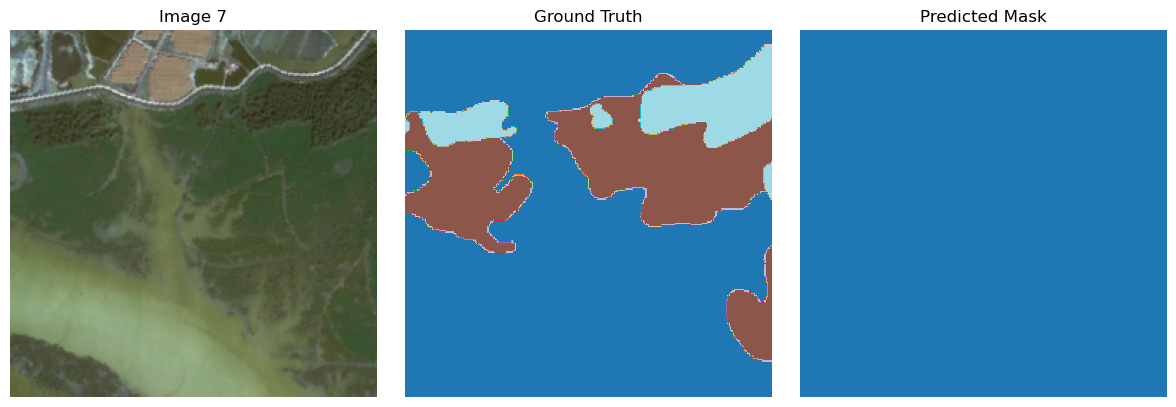

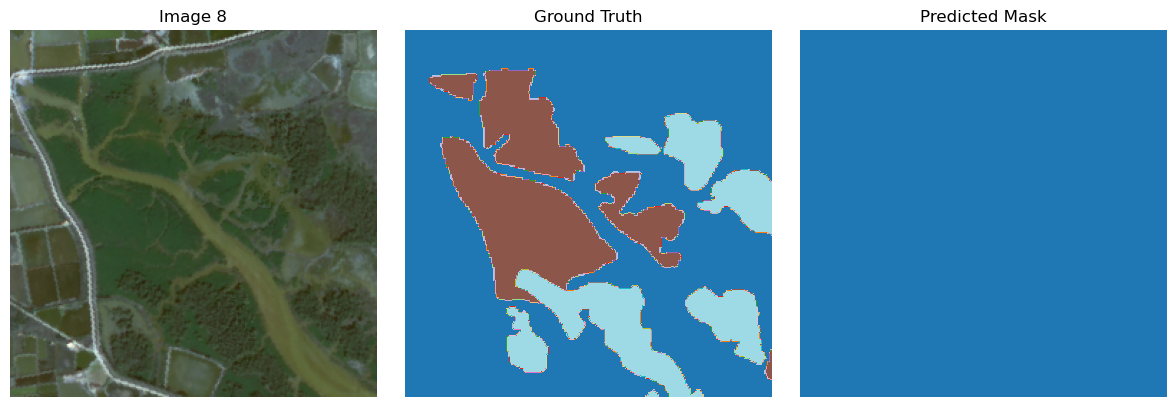

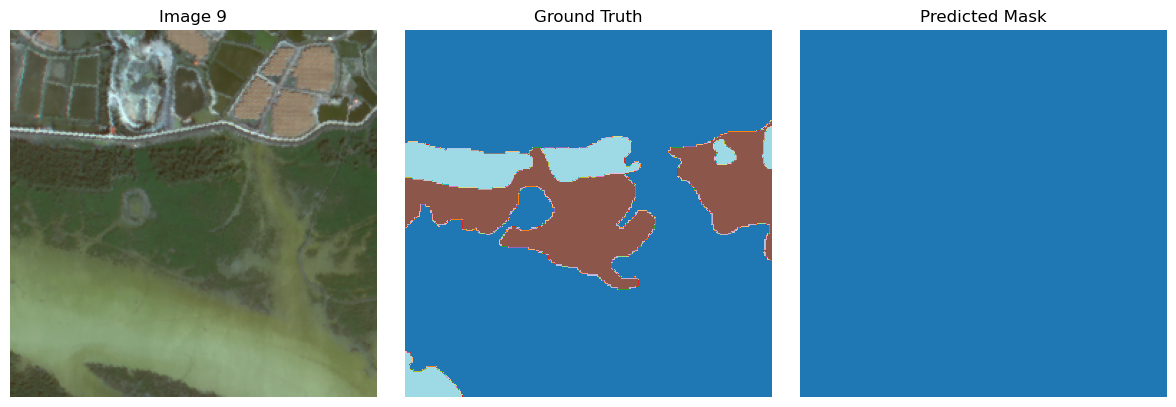

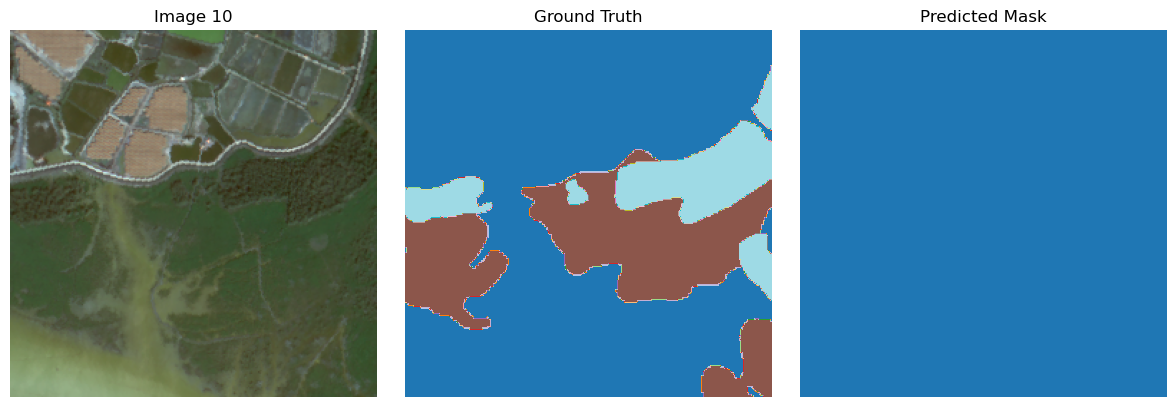

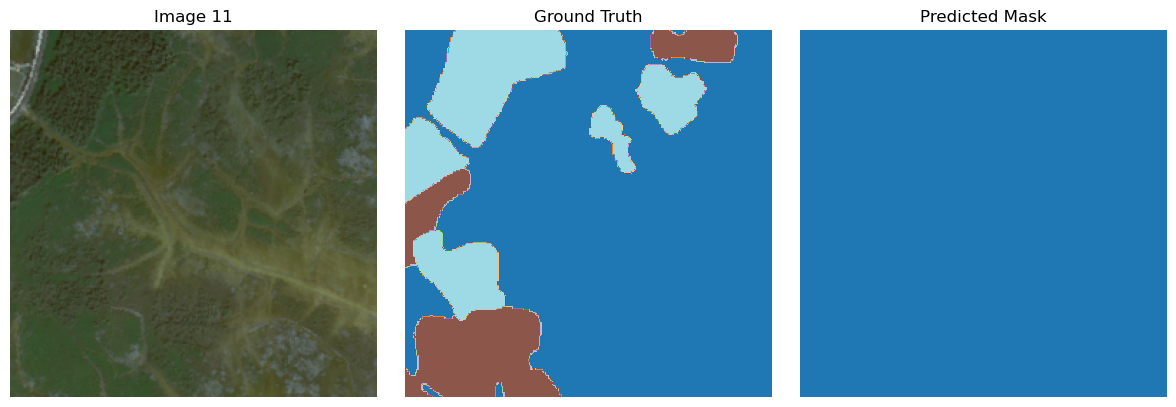

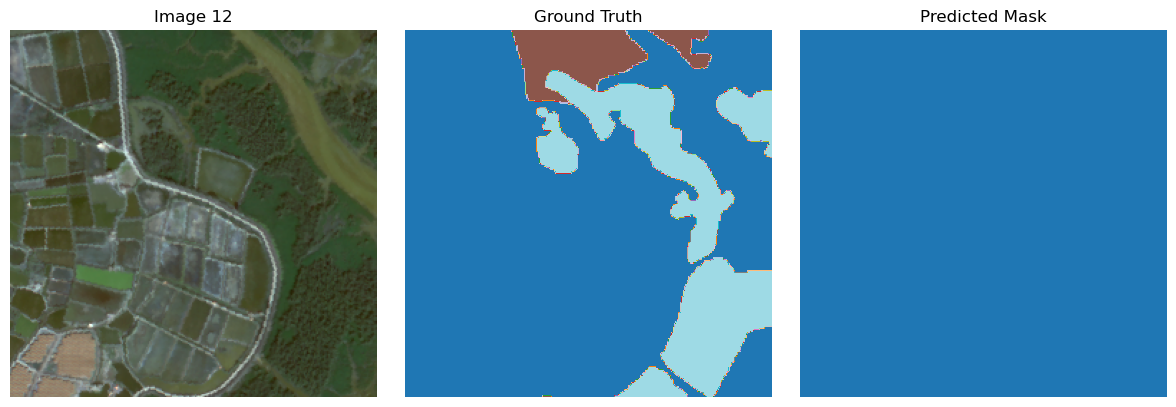

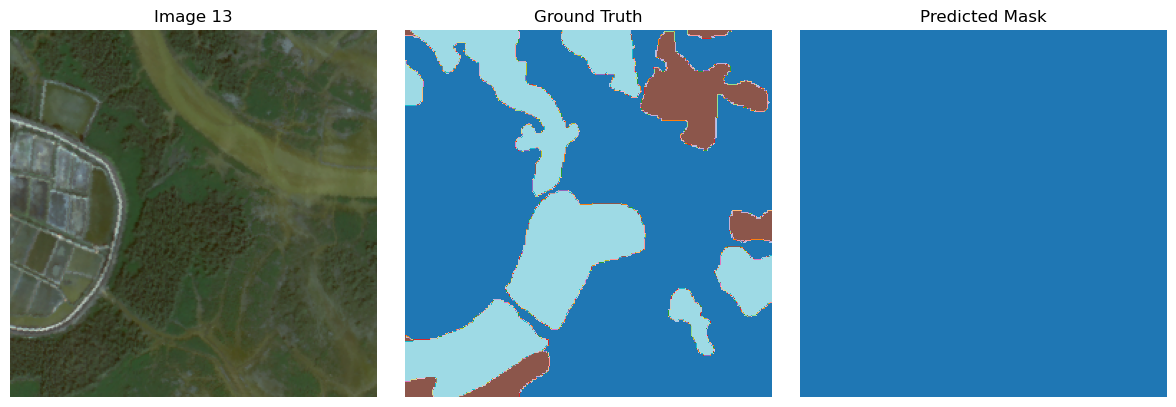

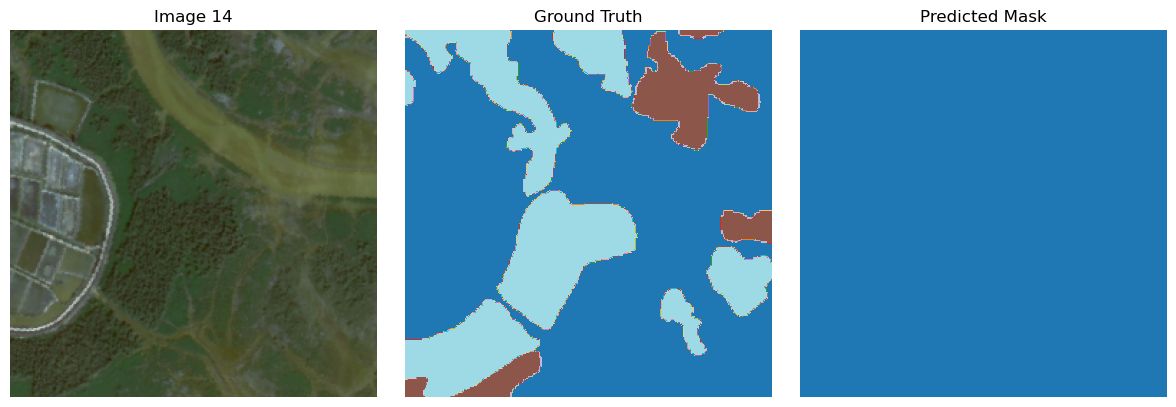

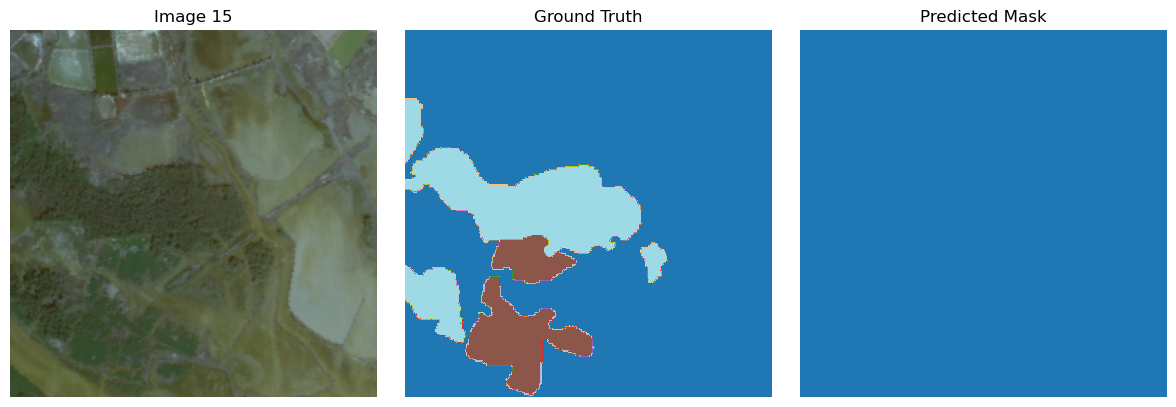

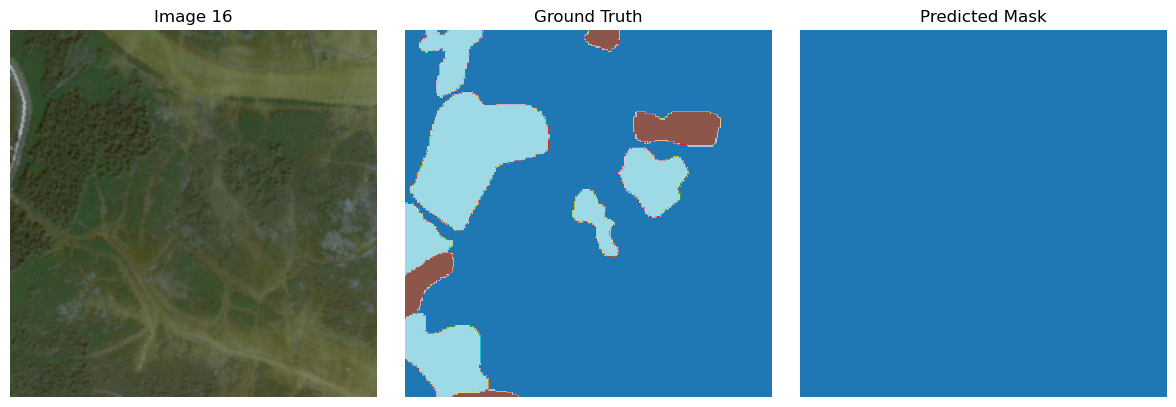

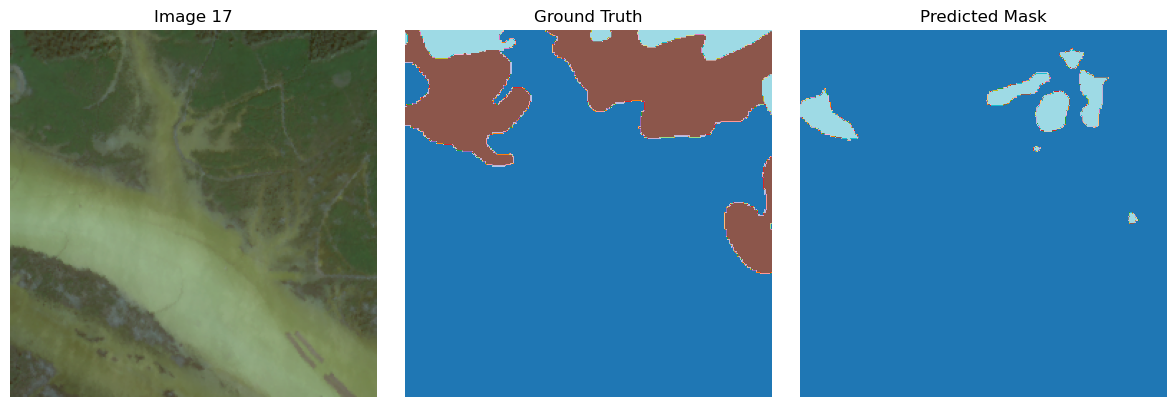

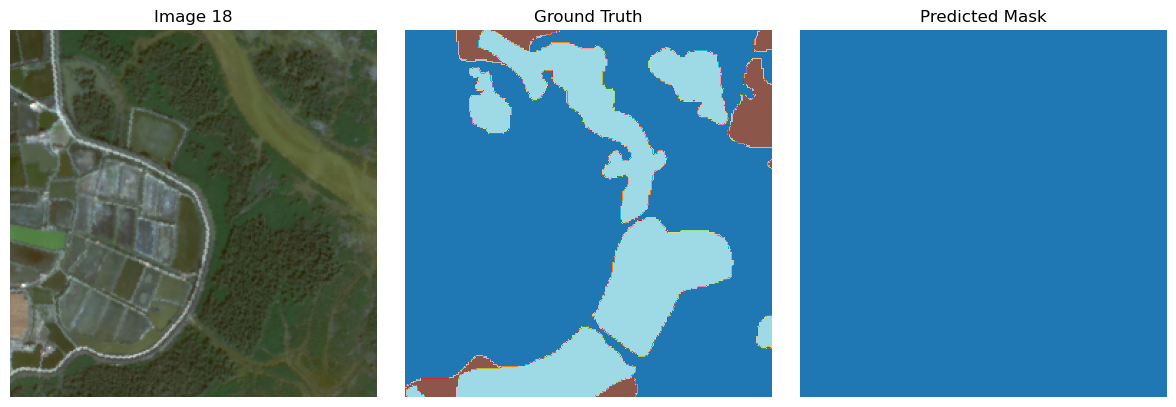

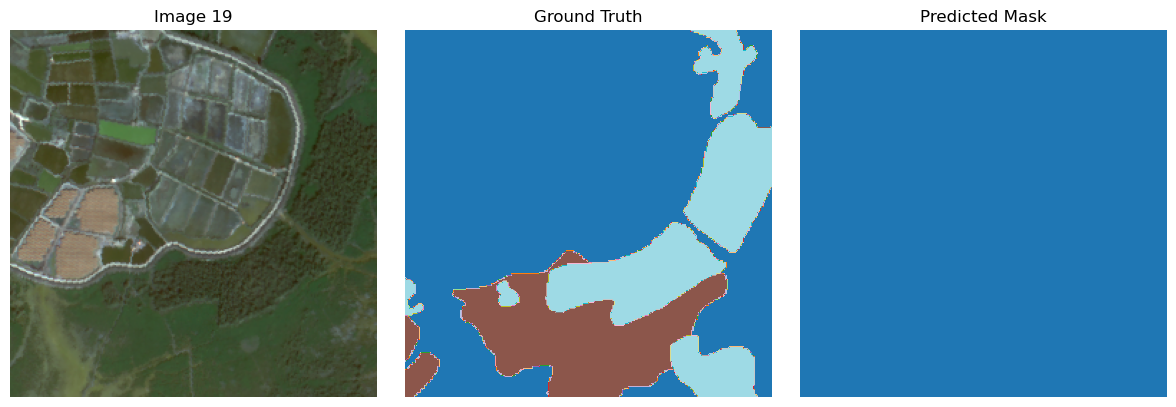

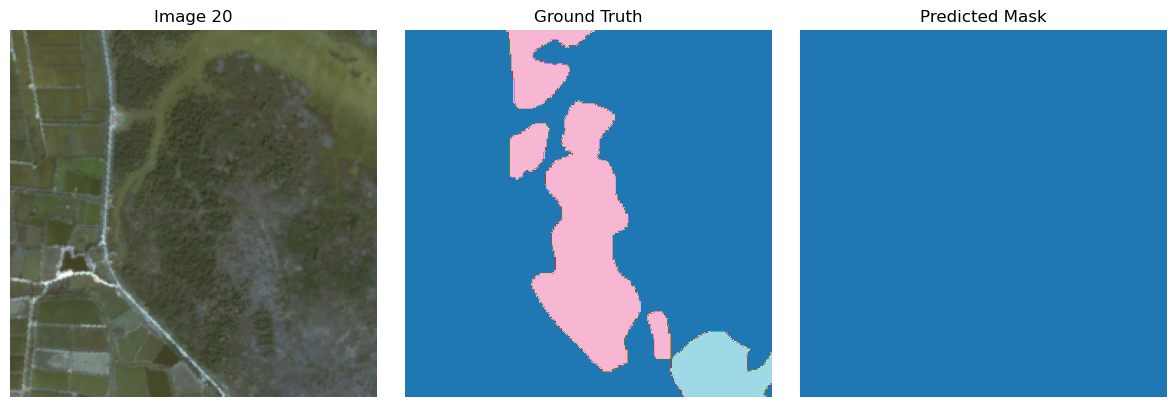

In [14]:
visual()

# Checkpoint

In [ ]:
import torch
model_path = models_path + "/Train_02.pth"
# 读取模型权重字典
state_dict = torch.load(model_path, map_location='cpu')

In [ ]:
model = SegNetODE(num_classes=5)
model.load_state_dict(state_dict)
# print(model.encoder.base.conv1.weight)  # 打印第一层卷积权重


for name, module in model.encoder.base.named_modules():
    if module.__class__.__name__ == 'BottleneckODE':
        print(f"Module name: {name}")
        for param_name, param in module.named_parameters():
            print(f"  Param: {param_name} | shape: {param.shape} | min: {param.min().item():.6f} | max: {param.max().item():.6f}")
        print('-'*50)


print(".....................")
print(torch.min(model.encoder.base.conv1.weight), torch.max(model.encoder.base.conv1.weight))